In [2]:
from shapely.affinity import rotate
from scipy.ndimage import rotate as scipy_rotate
import matplotlib.pyplot as plt

In [3]:
# get segmentation masks as polygon
from PIL import Image
from ultralytics import YOLO
import numpy as np
from shapely import Polygon
import rasterio.features
import easyocr

input_image = Image.open(r"..\test-data\book_shelf.jpg")
model = YOLO(r"yolov8_n_24aug2023.pt")
reader = easyocr.Reader(['en'])

results = model.predict(source=input_image, save=True, show_labels=False, show_conf=False, boxes=False)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.

0: 480x640 32 book-spines, 143.6ms
Speed: 4.0ms preprocess, 143.6ms inference, 33.9ms postprocess per image at shape (1, 3, 480, 640)
Results saved to e:\Code\shelfscan\runs\segment\predict15


In [28]:
mask_num = 13
bookspine_mask = results[0].masks.xy[mask_num]
mask_polygon = Polygon(bookspine_mask)

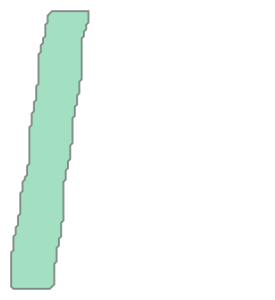

In [29]:
mask_polygon

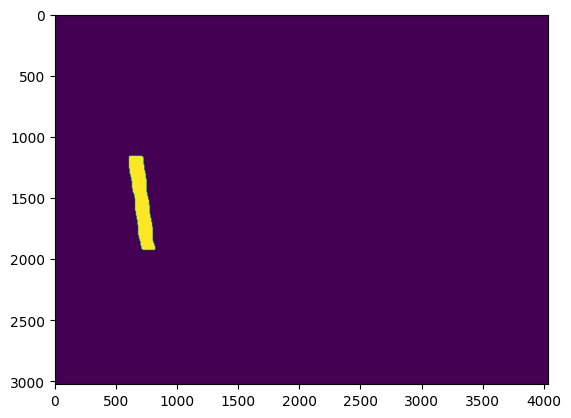

In [30]:
plt.imshow(rasterio.features.rasterize([mask_polygon], out_shape=(input_image.height, input_image.width)))

In [31]:
area = mask_polygon.area
centroid = mask_polygon.centroid.coords[0]

Ix = 0
Iy = 0
Ixy = 0

for i in range(len(mask_polygon.exterior.coords) - 1):
    xi, yi = mask_polygon.exterior.coords[i]
    xi1, yi1 = mask_polygon.exterior.coords[i + 1]

    Ai = xi * yi1 - xi1 * yi
    xi_avg = (xi + xi1) / 2
    yi_avg = (yi + yi1) / 2

    Ix += Ai * (yi_avg - centroid[1]) ** 2
    Iy += Ai * (xi_avg - centroid[0]) ** 2
    Ixy += Ai * (xi_avg - centroid[0]) * (yi_avg - centroid[1])
    
# Calculate the principal axis angle
theta_rad = 0.5 * np.arctan2(2 * Ixy, Ix - Iy)
theta_deg = np.degrees(theta_rad)

print("Principal Axis Angle:", theta_deg)

Principal Axis Angle: -82.17889575578609


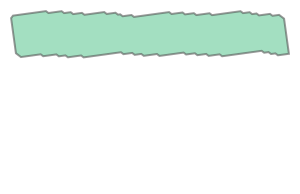

In [32]:
rotate_to_flat = -theta_deg
rotated_mask_polygon = rotate(mask_polygon, -rotate_to_flat)
rotated_mask_polygon

In [33]:
def get_polygon_bounds_for_slicing(mask_polygon):
    bounds_int = [int(_) for _ in mask_polygon.bounds] # .bounds returns floats, convert to int for slicing
    min_x, min_y, max_x, max_y = bounds_int
    return  min_x, min_y, max_x, max_y

In [34]:
mask_bitmap = rasterio.features.rasterize([mask_polygon], out_shape=(input_image.height, input_image.width))
input_image_bw = input_image.convert("L")
input_image_masked = input_image_bw * mask_bitmap
min_x, min_y, max_x, max_y = get_polygon_bounds_for_slicing(mask_polygon)
input_image_masked_bounded = input_image_masked[min_y:max_y,min_x:max_x]

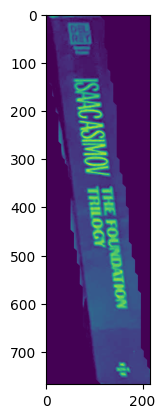

In [35]:
plt.imshow(input_image_masked_bounded)

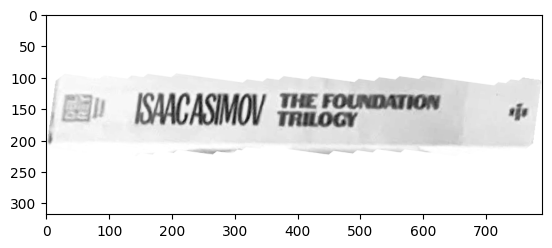

In [36]:
rotated_array_arbitrary = scipy_rotate(input_image_masked_bounded, rotate_to_flat, reshape=True)
plt.imshow(rotated_array_arbitrary, cmap='Greys')

In [37]:
def get_bookspine_text_from_ocr(ocr_results):
    return ' '.join([_[1] for _ in ocr_results])

In [38]:
bookspine_ocr = reader.readtext(rotated_array_arbitrary, detail=0)
print(bookspine_ocr)

['Ka', 'ISMACASIMOV', 'Witotronion', 'Janoor']


In [39]:
bs=1 # GPU only?
rotated_array_1 = scipy_rotate(rotated_array_arbitrary, 0, reshape=True)
bookspine_ocr = reader.readtext(rotated_array_1, batch_size=bs)
bookspine_text = get_bookspine_text_from_ocr(bookspine_ocr)
print(bookspine_text)
rotated_array_2 = scipy_rotate(rotated_array_arbitrary, 90, reshape=True)
bookspine_ocr = reader.readtext(rotated_array_2, batch_size=bs)
bookspine_text = get_bookspine_text_from_ocr(bookspine_ocr)
print(bookspine_text)
rotated_array_3 = scipy_rotate(rotated_array_arbitrary, 180, reshape=True)
bookspine_ocr = reader.readtext(rotated_array_3, batch_size=bs)
bookspine_text = get_bookspine_text_from_ocr(bookspine_ocr)
print(bookspine_text)
rotated_array_4 = scipy_rotate(rotated_array_arbitrary, 270, reshape=True)
bookspine_ocr = reader.readtext(rotated_array_4, batch_size=bs)
bookspine_text = get_bookspine_text_from_ocr(bookspine_ocr)
print(bookspine_text)

Ka ISMACASIMOV Witotronion Janoor
k 1
Joolul NOIVuNno In NOWNIHIWSI
9 1 1
